*Coursework done by Saad Mohammed Anis (2738059M).*

### Prerequisites

Check whether a GPU is available. Use it if available.

In [1]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))
    !nvidia-smi

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4
Sun Mar 12 13:18:38 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P0    29W /  70W |      3MiB / 15360MiB |      5%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                            

Install requirements.

In [2]:
!pip install transformers datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 37.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━

Import requirements.

In [3]:
import re
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from scipy import sparse

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.model_selection import ParameterGrid

from transformers import pipeline
from transformers import AutoModelForSequenceClassification, AutoTokenizer, set_seed
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding

from datasets import Dataset

import warnings
warnings.filterwarnings('ignore')

Load spaCy english pipeline. Increase pandas dataframe display maximum column width to 200.

In [4]:
nlp = spacy.load("en_core_web_sm")
pd.options.display.max_colwidth = 200

### Q1 - Dataset

This project assumes that the dataset has been downloaded and uploaded to Google Drive. The dataset is available to download from [here](https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment).

Mount Google Drive and read the CSV file.

In [5]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/tweets.csv', encoding='latin-1')

Mounted at /content/drive


Drop columns that are not required and get a random sampling of 10000.

In [6]:
df = df.drop(['tweet_id', 'airline_sentiment_confidence', 'negativereason_confidence', 'airline_sentiment_gold', 'name',
        'negativereason_gold', 'retweet_count', 'tweet_coord', 'tweet_created', 'tweet_location', 'user_timezone'], axis=1)
df = df.sample(n=10000, random_state=42)

display(df)

,airline_sentiment,negativereason,airline,text
4794,positive,NaN,Southwest,@SouthwestAir you're my early frontrunner for best airline! #oscars2016
10480,negative,Cancelled Flight,US Airways,@USAirways how is it that my flt to EWR was Cancelled Flightled yet flts to NYC from USAirways are still flying?
8067,negative,Late Flight,Delta,@JetBlue what is going on with your BDL to DCA flights yesterday and today?! Why is every single one getting delayed?
8880,neutral,NaN,Delta,"@JetBlue do they have to depart from Washington, D.C.??"
8292,negative,Customer Service Issue,Delta,@JetBlue I can probably find some of them. Are the ticket #s on there?
...,...,...,...,...
859,negative,Lost Luggage,United,@united GRK13575M is the file reference
2962,positive,NaN,United,@united thnx!
8089,positive,NaN,Delta,@JetBlue gr8 #Mint crew on #flight 123 to #LAX they're #Mintalicious #TrueBlueLove #ShelleyandMarcRock #travel #air
12408,neutral,NaN,American,@AmericanAir hi when will your next set of flights be out for next year from Dublin???


Split the dataset into a 60% training, 20% validation, and 20% testing dataset.

In [7]:
train, val, test = np.split(df, [int(.6*len(df)), int(.8*len(df))])

print('\tpositive\tneutral\t\tnegative\ttotal')
for name, split in {'train':train, 'val':val, 'test':test}.items():
    print(name, end='\t')
    for sentiment in ['positive', 'neutral', 'negative']:
        print(split['airline_sentiment'].value_counts()[sentiment], end='\t\t')
    print(len(split))

	positive	neutral		negative	total
train	958		1232		3810		6000
val	324		424		1252		2000
test	322		426		1252		2000


Separate the labels of each split into a list.

In [8]:
train_labels = train['airline_sentiment'].tolist()
val_labels = val['airline_sentiment'].tolist()
test_labels = test['airline_sentiment'].tolist()

### Q2 - Clustering

#### Vectorize Text

Create a tokenizer pipeline that separates numbers and punctuations, removes stopwords, punctuations, spaces, @ mentions, and links.

In [ ]:
def text_pipeline_spacy(text):
    text = re.sub('(\d+(\.\d+)?)', r' \1 ', text).strip()
    punctuation = "[" + re.escape('!"#$%&\'()*+,-./:;<=>?[\]^_`{|}~') + "]"
    text = re.sub(punctuation, r" \g<0> ", text)
    tokens = []
    doc = nlp(text)
    for t in doc:
        if not t.is_stop and not t.is_punct and not t.is_space and not re.search("^@.*", t.text) \
        and not re.search("^http.*", t.text) and not re.search("^https.*", t.text) and not \
        len(t) == 1:
            tokens.append(t.lemma_.lower())
    return tokens

example_1 = df['text'].values[0]
print('Original text:', example_1)
example_1_processed = text_pipeline_spacy(example_1)
print('Processed text:', example_1_processed)

Original text: @SouthwestAir you're my early frontrunner for best airline! #oscars2016
Processed text: ['early', 'frontrunner', 'good', 'airline', 'oscar', '2016']


Vectorize the dataset using `TfidfVectorizer` with the spacy pipeline. 

In [ ]:
vectorizer = TfidfVectorizer(tokenizer=text_pipeline_spacy)
sparse_vectors = vectorizer.fit_transform(df['text'])

#### Perform K-Means Clustering

Define helper functions.

* `initial_centroids`: create `k` centroids randomly from the vectorized dataset `sparse_vectors`.
* `assign_centroids`: assign each `sparse_vector` to a centroid using cosine similarity.
* `update_centroid`: calculate the new centroids.

In [ ]:
def initial_centroids(sparse_vectors, k, seed): 
    np.random.seed(seed)
    return sparse_vectors[np.random.choice(sparse_vectors.shape[0], k), :]

def assign_centroids(sparse_vectors, centroids):
    cosine_similarities = cosine_similarity(sparse_vectors, centroids)
    return np.array([[np.argmax(row),row[np.argmax(row)]] for row in cosine_similarities])

def update_centroid(sparse_vectors, y):
    new_centroids = sparse.csr_matrix((0,sparse_vectors.shape[1]))
    for i in set(y):
        new_centroid = sparse_vectors[np.where(y == np.array(i))].mean(axis=0)
        new_centroids = sparse.vstack([new_centroids, new_centroid])
    return new_centroids

Define the `k_means` function.

Parameters:
* `sparse_vectors`: the dataset, vectorized.
* `k`: the number of clusters.
* `max_iterations`: the maximum number of iterations.
* `seed`: the random seed for the initial centroid assignment.

Returns:
* `y`: 2d array denoting col 0 for the index of the assigned centroid, and col 1 for cosine similarity with centroid.
* `centroids`: the final list of centroids.

In [ ]:
def k_means(sparse_vectors, k, max_iterations, seed):

    centroids = initial_centroids(sparse_vectors, k, seed)

    for i in range(max_iterations):
        y = assign_centroids(sparse_vectors, centroids)
        new_centroids = update_centroid(sparse_vectors, y[:,0])
        if(centroids.shape == new_centroids.shape):
            if (centroids!=new_centroids).nnz == 0:
                print(f'Converged in {i} iterations.')
                break
        centroids = new_centroids
    
    y = assign_centroids(sparse_vectors, centroids)

    return y, centroids

Run the `k_means` function with five clusters.

In [ ]:
y, centroids = k_means(sparse_vectors, 5, 100, 42)

Converged in 41 iterations.


#### Inspect Results

Inspect the top five tokens with the highest magnitude for each centroid.

In [ ]:
vocabulary_tokens = {v: k for k, v in vectorizer.vocabulary_.items()}

for i in set(y[:,0]):
    print(f'cluster {int(i)}:', end=" ")
    centroid = centroids.getrow(i).toarray()[0]
    indices = np.argpartition(centroid, -5)[-5:]
    for j in indices[::-1]:
        print(vocabulary_tokens[j], end=" ")
    print()

cluster 0: thank send dm follow great 
cluster 1: flightle cancel flight delay late 
cluster 2: wait hour plane hold delay 
cluster 3: booking problem flight reflight helpful 
cluster 4: co service customer fly help 


Inspect five documents that have the highest similarity with their corresponding centroids.

In [ ]:
tcs = pd.DataFrame({
    'text': df['text'].tolist(),
    'cluster': y[:,0],
    'similarity': y[:,1]
}).sort_values(by=['cluster','similarity'], ascending=False)

for i in set(y[:,0]):
    display(tcs[tcs['cluster']==i][0:5])

,text,cluster,similarity
57,@JetBlue I will. Thank you!,0.0,0.930653
133,@AmericanAir thanks,0.0,0.930653
197,@united I will. Thanks.,0.0,0.930653
474,"@AmericanAir thanks, me too",0.0,0.930653
507,@AmericanAir @contactcej thanks!,0.0,0.930653


,text,cluster,similarity
2796,@VirginAmerica On all your flights?,1.0,0.788174
2988,@USAirways and if the flight is full?,1.0,0.788174
6511,@united are you telling me that you are now Cancelled Flighting my flight ??,1.0,0.683020
4480,@USAirways Just Cancelled Flight every flight I have why don't you.,1.0,0.676941
8469,@SouthwestAir Can I get any help with Cancelled Flighting my flight reservation?,1.0,0.606595


,text,cluster,similarity
5066,@AmericanAir been waiting on hold for more than an hour,2.0,0.628986
253,@USAirways been on hold for over and hour now.,2.0,0.547036
1802,@USAirways @AmericanAir how do I get thru on hold over 3 hours ?,2.0,0.547036
2020,@AmericanAir I was told I had a 20minute wait time after waiting hours. And an hour has gone by. This is ridiculous,2.0,0.525975
1783,"@AmericanAir Also, I have to wait more than 2 hours before I can speak to someone on the phone? I can't wait 2 hours. :(",2.0,0.509892


,text,cluster,similarity
8094,"@VirginAmerica And now the flight Flight Booking Problems site is totally down. Folks, what is the problem?",3.0,0.657614
853,@united No. The entire problem here is that I was never sent anything via email and only given a Flight Booking Problems number over the phone.,3.0,0.643975
5925,@united My flight was Cancelled Flighted and I'm needing some help reFlight Booking Problems.,3.0,0.613423
9970,"@AmericanAir When Flight Booking Problems an int'l flight online, do I have to provide a passport number when Flight Booking Problems or just when I arrive at airport?",3.0,0.607777
3395,@USAirways Thanks for Cancelled Flighting my flight tomorrow and not reFlight Booking Problems me on another one. #usairwaysfail,3.0,0.585612


,text,cluster,similarity
5037,@SouthwestAir has the WORST customer service of any airline I've ever flown.,4.0,0.410839
4585,"@USAirways please help! No bags, no way to get through to customer service since 8AM this morning! Help!!",4.0,0.346755
9297,@USAirways WORST customer service ever!!!,4.0,0.345127
5876,@SouthwestAir has the best customer service!,4.0,0.337879
5591,"@JetBlue If this is customer service, then please call me.",4.0,0.336458


#### Create Confusion Matrix

Print the confusion matrix.

In [ ]:
print('Count of labels in each cluster:')
print('cluster\t\tpositive\tneutral\t\tnegative\ttotal')
for i in set(y[:,0]):
    print(f"{int(i)}", end='\t\t')
    for sentiment in ['positive', 'neutral', 'negative']:
        print(df.iloc[np.where(y[:,0] == np.array(i))]['airline_sentiment'].value_counts()[sentiment], end='\t\t')
    print(df.iloc[np.where(y[:,0] == np.array(i))]['airline_sentiment'].size)

Count of labels in each cluster:
cluster		positive	neutral		negative	total
0		749		290		256		1295
1		161		452		1604		2217
2		68		146		1496		1710
3		24		44		182		250
4		602		1150		2776		4528


Percentage of division of labels over the clusters.

In [ ]:
print('Percentage of labels in each cluster:')
print('cluster\t\tpositive\tneutral\t\tnegative')
for i in set(y[:,0]):
    size = df.iloc[np.where(y[:,0] == np.array(i))]['airline_sentiment'].size
    print(f"{int(i)}", end='\t\t')
    for sentiment in ['positive', 'neutral', 'negative']:
        count = df.iloc[np.where(y[:,0] == np.array(i))]['airline_sentiment'].value_counts()[sentiment]
        print(round(count*100/size, 1), end='\t\t')
    print()

Percentage of labels in each cluster:
cluster		positive	neutral		negative
0		57.8		22.4		19.8		
1		7.3		20.4		72.4		
2		4.0		8.5		87.5		
3		9.6		17.6		72.8		
4		13.3		25.4		61.3		


### Q3 - Comparing Classifiers

#### Vectorize The Datasets

Create the TF-IDF Vectorizer and vectorize the splits.

In [ ]:
vectorizer_tfidf = TfidfVectorizer(tokenizer=text_pipeline_spacy)
vectorizer_tfidf.fit(train['text'])

train_tfidf = vectorizer_tfidf.transform(train['text'])
val_tfidf = vectorizer_tfidf.transform(val['text'])
test_tfidf = vectorizer_tfidf.transform(test['text'])

Create the One-hot Vectorizer and vectorize the splits.

In [ ]:
vectorizer_1h = CountVectorizer(tokenizer=text_pipeline_spacy, binary=True)
vectorizer_1h.fit(train['text'])

train_1h = vectorizer_1h.transform(train['text'])
val_1h = vectorizer_1h.transform(val['text'])
test_1h = vectorizer_1h.transform(test['text'])

#### Train The Classifiers

Train the `DummyClassifier` classifier with `strategy='most_frequent'`.

In [ ]:
dummy_most_frequent = DummyClassifier(strategy='most_frequent')
dummy_most_frequent.fit(train_tfidf, train_labels)

val_pred = dummy_most_frequent.predict(val_tfidf)
print(classification_report(val_labels, val_pred))

              precision    recall  f1-score   support

    negative       0.63      1.00      0.77      1252
     neutral       0.00      0.00      0.00       424
    positive       0.00      0.00      0.00       324

    accuracy                           0.63      2000
   macro avg       0.21      0.33      0.26      2000
weighted avg       0.39      0.63      0.48      2000



Train the `DummyClassifier` classifier with `strategy='stratified'`.

In [ ]:
dummy_stratified = DummyClassifier(strategy='stratified')
dummy_stratified.fit(train_tfidf, train_labels)

val_pred = dummy_stratified.predict(val_tfidf)
print(classification_report(val_labels, val_pred))

              precision    recall  f1-score   support

    negative       0.63      0.64      0.64      1252
     neutral       0.23      0.23      0.23       424
    positive       0.15      0.14      0.14       324

    accuracy                           0.47      2000
   macro avg       0.34      0.34      0.34      2000
weighted avg       0.47      0.47      0.47      2000



Train the `LogisticRegresssion` classifier with one-hot vectorization.

In [ ]:
logistic_1h = LogisticRegression(random_state=42, max_iter=1000)
logistic_1h.fit(train_1h, train_labels)

val_pred = logistic_1h.predict(val_1h)
print(classification_report(val_labels, val_pred))

              precision    recall  f1-score   support

    negative       0.82      0.87      0.85      1252
     neutral       0.60      0.53      0.56       424
    positive       0.74      0.68      0.71       324

    accuracy                           0.77      2000
   macro avg       0.72      0.69      0.71      2000
weighted avg       0.76      0.77      0.76      2000



Train the `LogisticRegression` classifier with TF-IDF vectorization.

In [ ]:
logistic_tfidf = LogisticRegression(random_state=42)
logistic_tfidf.fit(train_tfidf, train_labels)

val_pred = logistic_tfidf.predict(val_tfidf)
print(classification_report(val_labels, val_pred))

              precision    recall  f1-score   support

    negative       0.77      0.95      0.85      1252
     neutral       0.69      0.36      0.47       424
    positive       0.79      0.56      0.65       324

    accuracy                           0.76      2000
   macro avg       0.75      0.62      0.66      2000
weighted avg       0.75      0.76      0.74      2000



Train the `SVC` classifier with one-hot vectorization.

In [ ]:
svc = SVC(random_state=42)
svc.fit(train_1h, train_labels)

val_pred = svc.predict(val_1h)
print(classification_report(val_labels, val_pred))

              precision    recall  f1-score   support

    negative       0.79      0.93      0.86      1252
     neutral       0.67      0.44      0.53       424
    positive       0.76      0.60      0.67       324

    accuracy                           0.77      2000
   macro avg       0.74      0.66      0.69      2000
weighted avg       0.76      0.77      0.76      2000



#### Calculate Metrics

Create a function to evaluate and calculate the accuracy, macro-average precision, recall, and F1 scores.

In [ ]:
def calculate_metrics(model, X, y):
    y_pred = model.predict(X)
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, average='macro')
    recall = recall_score(y, y_pred, average='macro')
    f1 = f1_score(y, y_pred, average='macro')
    return accuracy, precision, recall, f1

Calculate the metrics and display in a `DataFrame`.

In [ ]:
overall_metrics = pd.DataFrame(columns=['model','vectorizer', 'split', 'accuracy','precision','recall','f1'])

for i, model in enumerate([
    (dummy_most_frequent, 'DummyClassifier', '-'),
    (dummy_stratified, 'DummyClassifier', '-'),
    (logistic_tfidf, 'LogisticRegression', 'TF-IDF'),
    (logistic_1h, 'LogisticRegression', 'One-hot'),
    (svc, 'SVC', 'One-hot')]):
    if i < 3:
        splits = [(train_tfidf, train_labels, 'train'),
                  (val_tfidf, val_labels, 'val')]
    else:
        splits = [(train_1h, train_labels, 'train'),
                  (val_1h, val_labels, 'val')]
    for split in splits:
        metrics = calculate_metrics(model[0], split[0], split[1])
        metric = pd.DataFrame({
            'model': [model[1]],
            'vectorizer': [model[2]],
            'split': [split[2]],
            'accuracy': [round(metrics[0], 3)],
            'precision': [round(metrics[1], 3)],
            'recall': [round(metrics[2], 3)],
            'f1': [round(metrics[3], 3)]
        })
        overall_metrics = pd.concat([overall_metrics, metric], ignore_index=True)
            # overall_metrics.concat(metric, ignore_index=True)

display(overall_metrics)

,model,vectorizer,split,accuracy,precision,recall,f1
0,DummyClassifier,-,train,0.635,0.212,0.333,0.259
1,DummyClassifier,-,val,0.626,0.209,0.333,0.257
2,DummyClassifier,-,train,0.470,0.331,0.331,0.331
3,DummyClassifier,-,val,0.456,0.320,0.320,0.320
4,LogisticRegression,TF-IDF,train,0.869,0.889,0.776,0.819
5,LogisticRegression,TF-IDF,val,0.762,0.748,0.623,0.659
6,LogisticRegression,One-hot,train,0.940,0.933,0.909,0.920
7,LogisticRegression,One-hot,val,0.768,0.721,0.694,0.706
8,SVC,One-hot,train,0.920,0.915,0.869,0.890
9,SVC,One-hot,val,0.772,0.743,0.657,0.686


Create a bar chart for the individual F1 scores for the best performing classifier on the validation set, the `LogisticRegression` classifier with the one-hot vectorization.

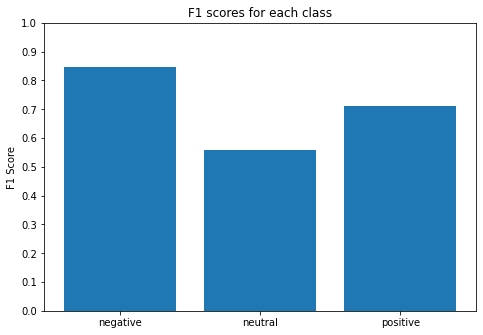

In [ ]:
val_pred = logistic_1h.predict(val_1h)
precision, recall, f1, support = precision_recall_fscore_support(val_labels, val_pred)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = ['negative','neutral','positive']
ax.bar(labels, f1)
ax.set_title('F1 scores for each class')
ax.set_ylabel('F1 Score')
ax.set_yticks(np.linspace(0, 1, 11))
plt.show()

#### Try a Different Classifier

Create a Term Frequency Vectorizer and vectorize the splits.

In [ ]:
vectorizer_tf = CountVectorizer(tokenizer=text_pipeline_spacy)
vectorizer_tf.fit(train['text'])

train_tf = vectorizer_tf.transform(train['text'])
val_tf = vectorizer_tf.transform(val['text'])
test_tf = vectorizer_tf.transform(test['text'])

Train the `MultinomialNB` classifier with count vectorization.

In [ ]:
multinomial = MultinomialNB()
multinomial.fit(train_tf, train_labels)

val_pred = multinomial.predict(val_tf)
print(classification_report(val_labels, val_pred))

accuracy, precision, recall, f1 = calculate_metrics(multinomial, val_tf, val_labels)
print('accuracy:\t', round(accuracy, 3))
print('precision:\t', round(precision, 3))
print('recall:\t\t', round(recall, 3))
print('f1:\t\t', round(f1, 3))

              precision    recall  f1-score   support

    negative       0.74      0.96      0.84      1252
     neutral       0.73      0.30      0.42       424
    positive       0.77      0.49      0.60       324

    accuracy                           0.74      2000
   macro avg       0.75      0.58      0.62      2000
weighted avg       0.74      0.74      0.71      2000

accuracy:	 0.744
precision:	 0.749
recall:		 0.583
f1:		 0.62


### Q4 - Parameter Tuning

Use `ParameterGrid` to find the best values of `C`, `sublinear_tf`, and `max_features`. Additionally, compare the progress with and without the use of the `text_pipeline_spacy` tokenizer.

In [ ]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000],
    'max_features': [None, 915, 1830, 3660, 7318],
    'sublinear_tf': [True, False],
    'tokenizer': [text_pipeline_spacy, None]
}

best_params, best_classifier = None, None
best_accuracy, best_precision, best_recall, best_f1 = 0, 0, 0, 0

for params in ParameterGrid(param_grid):
    vectorizer = TfidfVectorizer(
        tokenizer=params['tokenizer'],
        sublinear_tf=params['sublinear_tf'],
        max_features=params['max_features']
    )
    
    train_vectors = vectorizer.fit_transform(train['text'])
    val_vectors = vectorizer.transform(val['text'])
    
    classifier = LogisticRegression(random_state=42, C=params['C'])
    classifier.fit(train_vectors,train_labels)
    
    predicted_labels = classifier.predict(val_vectors)
    
    accuracy, precision, recall, f1 = calculate_metrics(classifier, val_vectors, val_labels)

    if f1 > best_f1:
        best_params = params
        best_f1 = f1
        best_accuracy = accuracy
        best_precision = precision
        best_recall = recall
        best_classifier = classifier
        print(f'current best f1: {f1:.3f}\ncurrent best params: {params}\n')

print(f'overall best f1: {best_f1:.3f}\noverall best params: {best_params}')

current best f1: 0.257
current best params: {'C': 0.001, 'max_features': None, 'sublinear_tf': True, 'tokenizer': <function text_pipeline_spacy at 0x7fc813fd5940>}

current best f1: 0.312
current best params: {'C': 0.01, 'max_features': None, 'sublinear_tf': True, 'tokenizer': <function text_pipeline_spacy at 0x7fc813fd5940>}

current best f1: 0.313
current best params: {'C': 0.01, 'max_features': 915, 'sublinear_tf': True, 'tokenizer': <function text_pipeline_spacy at 0x7fc813fd5940>}

current best f1: 0.474
current best params: {'C': 0.1, 'max_features': None, 'sublinear_tf': True, 'tokenizer': <function text_pipeline_spacy at 0x7fc813fd5940>}

current best f1: 0.511
current best params: {'C': 0.1, 'max_features': None, 'sublinear_tf': True, 'tokenizer': None}

current best f1: 0.541
current best params: {'C': 0.1, 'max_features': 915, 'sublinear_tf': True, 'tokenizer': <function text_pipeline_spacy at 0x7fc813fd5940>}

current best f1: 0.564
current best params: {'C': 0.1, 'max_feat

In [ ]:
baseline_metrics = calculate_metrics(logistic_tfidf, val_tfidf, val_labels)

pd.DataFrame.from_dict({
    'Classifier': ['Baseline', 'Tuned'],
    'Accuracy': [round(baseline_metrics[0], 3), round(best_accuracy, 3)],
    'Precision': [round(baseline_metrics[1], 3), round(best_precision, 3)],
    'Recall': [round(baseline_metrics[2], 3), round(best_recall, 3)],
    'F1': [round(baseline_metrics[3], 3), round(best_f1, 3)]
})

,Classifier,Accuracy,Precision,Recall,F1
0,Baseline,0.762,0.748,0.623,0.659
1,Tuned,0.798,0.783,0.697,0.730


### Q5 - Context Vectors Using BERT

#### Feature Extraction and Classification

Load `feature-extraction` pipeline with the `roberta-base` model.

In [ ]:
pipe = pipeline('feature-extraction', model='roberta-base')

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Get the first context vectors for the training and validation sets from the pipeline.

In [ ]:
train_context_vectors = [doc[0][0] for doc in pipe(train['text'].tolist())]
val_context_vectors = [doc[0][0] for doc in pipe(val['text'].tolist())]

Create the `LogisticRegression` model, fit on the training set, and evaluate on the validation set.

In [ ]:
logistic_roberta = LogisticRegression(random_state=42, max_iter=1000)
logistic_roberta.fit(train_context_vectors, train_labels)

val_pred = logistic_roberta.predict(val_context_vectors)
print(classification_report(val_labels, val_pred))

accuracy, precision, recall, f1 = calculate_metrics(logistic_roberta, val_context_vectors, val_labels)
print('accuracy:\t', round(accuracy, 3))
print('precision:\t', round(precision, 3))
print('recall:\t\t', round(recall, 3))
print('f1:\t\t', round(f1, 3))

              precision    recall  f1-score   support

    negative       0.86      0.92      0.89      1252
     neutral       0.71      0.58      0.64       424
    positive       0.79      0.75      0.77       324

    accuracy                           0.82      2000
   macro avg       0.79      0.75      0.77      2000
weighted avg       0.82      0.82      0.82      2000

accuracy:	 0.822
precision:	 0.786
recall:		 0.751
f1:		 0.766


#### Train End-to-End Classifier

Initialize the model, tokenizer, and data collator.

In [28]:
set_seed(42)
model = AutoModelForSequenceClassification.from_pretrained('roberta-base', num_labels=3)
tokenizer = AutoTokenizer.from_pretrained("roberta-base")
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/bc2764f8af2e92b6eb5679868df33e224075ca68/config.json
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading 

Define the following helper functions.
* `label_to_int`: convert the labels negative, neutral, and positive to 0, 1, and 2 respectively.
* `int_to_label`: convert the integers 0, 1, and 2 to negative, neutral, and positive respectively.
* `convert_to_dataset`: convert the dataframe into a dataset compatible for training.

In [29]:
def label_to_int(label):
  if label == 'negative':
    return 0
  elif label == 'neutral':
    return 1
  elif label == 'positive':
    return 2
  else:
    return None

def int_to_label(i):
  if i == 2:
    return 'positive'
  elif i == 1:
    return 'neutral'
  elif i == 0:
    return 'negative'
  else:
    return None

def convert_to_dataset(split):
  dataset = Dataset.from_pandas(split)
  dataset = dataset.map(lambda example: {'text': example['text'], 'label': label_to_int(example['airline_sentiment'])})
  dataset = dataset.remove_columns(['airline_sentiment', 'airline', 'negativereason', '__index_level_0__'])
  return dataset

Convert training and validation sets into compatible datasets.

In [30]:
train_dataset = convert_to_dataset(train)
val_dataset = convert_to_dataset(val)

display(train_dataset)
display(val_dataset)

Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'label'],
    num_rows: 6000
})

Dataset({
    features: ['text', 'label'],
    num_rows: 2000
})

Create a `tokenize_function` that tokenizes the examples. Tokenize the training and validation datasets.


In [31]:
def tokenize_function(tokenizer, examples):
  return tokenizer(examples['text'], truncation=True)

tokenized_train_dataset = train_dataset.map(lambda examples: tokenize_function(tokenizer, examples), batched=True)
tokenized_val_dataset = val_dataset.map(lambda examples: tokenize_function(tokenizer, examples), batched=True)

Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Initialize the training arguments and trainer.

In [32]:
training_args = TrainingArguments(
    output_dir="roberta_coursework",
    evaluation_strategy="epoch",
    learning_rate=1e-4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


Train the model.

In [33]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 6000
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 375
  Number of trainable parameters = 124647939
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss
1,No log,0.478887


The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 16


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=375, training_loss=0.67179052734375, metrics={'train_runtime': 70.1495, 'train_samples_per_second': 85.532, 'train_steps_per_second': 5.346, 'total_flos': 144983715462432.0, 'train_loss': 0.67179052734375, 'epoch': 1.0})

Predict on the validation dataset. Find the prediction labels from the prediction logits and convert to labels.

In [34]:
predictions, label_ids, metrics = trainer.predict(tokenized_val_dataset)
val_preds = [int_to_label(i) for i in np.argmax(predictions, axis=1)]

print(classification_report(val_labels, val_preds))

accuracy = accuracy_score(val_labels, val_preds)
precision = precision_score(val_labels, val_preds, average='macro')
recall = recall_score(val_labels, val_preds, average='macro')
f1 = f1_score(val_labels, val_preds, average='macro')

print('accuracy:\t', round(accuracy, 3))
print('precision:\t', round(precision, 3))
print('recall:\t\t', round(recall, 3))
print('f1:\t\t', round(f1, 3))

The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 2000
  Batch size = 16


              precision    recall  f1-score   support

    negative       0.88      0.90      0.89      1252
     neutral       0.69      0.59      0.64       424
    positive       0.72      0.81      0.76       324

    accuracy                           0.82      2000
   macro avg       0.77      0.77      0.76      2000
weighted avg       0.82      0.82      0.82      2000

accuracy:	 0.82
precision:	 0.766
recall:		 0.766
f1:		 0.764


#### Train Using Different Hyperparameters

Set up three sets of hyperparameters.

In [ ]:
model_name = ['distilbert-base-uncased','bert-base-uncased','cardiffnlp/twitter-roberta-base-sentiment']
learning_rate = [1e-6, 1e-4, 1e-5]
epochs = [20, 5, 3]
batch_size = [8, 32, 16]

For the three sets of hyperparameters, recreate the model, tokenizer, and data collator. Re-tokenizer the datasets with the new tokenizer. Create the training arguments and trainer. Then perform the training.

After the training, predict on the validation set and append the validation labels to the `val_preds` list.

In [ ]:
val_preds = []

for i in range(3):

  model=AutoModelForSequenceClassification.from_pretrained(model_name[i], num_labels=3)
  tokenizer = AutoTokenizer.from_pretrained(model_name[i])
  data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

  tokenized_train_dataset = train_dataset.map(lambda examples: tokenize_function(tokenizer, examples), batched=True)
  tokenized_val_dataset = val_dataset.map(lambda examples: tokenize_function(tokenizer, examples), batched=True)

  training_args = TrainingArguments(
      output_dir="coursework",
      evaluation_strategy="epoch",
      learning_rate=learning_rate[i],
      per_device_train_batch_size=batch_size[i],
      per_device_eval_batch_size=batch_size[i],
      num_train_epochs=epochs[i]
  )

  trainer = Trainer(
      model=model,
      args=training_args,
      train_dataset=tokenized_train_dataset,
      eval_dataset=tokenized_val_dataset,
      tokenizer=tokenizer,
      data_collator=data_collator
  )

  trainer.train()
  predictions, label_ids, metrics = trainer.predict(tokenized_val_dataset)
  val_preds.append([int_to_label(i) for i in np.argmax(predictions, axis=1)])

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}



loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/pytorch_model.bin
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBert

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}



loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/tokenizer_config.json
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropo

Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 6000
  Num Epochs = 20
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 15000
  Number of trainable parameters = 66955779
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a 

Epoch,Training Loss,Validation Loss
1,0.899500,0.765069
2,0.711700,0.672311
3,0.649000,0.605044
4,0.561100,0.544354
5,0.515900,0.484038
6,0.446500,0.467717
7,0.439600,0.465280
8,0.407100,0.468625
9,0.407600,0.468520
10,0.402000,0.467907


Saving model checkpoint to coursework/checkpoint-500
Configuration saved in coursework/checkpoint-500/config.json
Model weights saved in coursework/checkpoint-500/pytorch_model.bin
tokenizer config file saved in coursework/checkpoint-500/tokenizer_config.json
Special tokens file saved in coursework/checkpoint-500/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 8
Saving model checkpoint to coursework/checkpoint-1000
Configuration saved in coursework/checkpoint-1000/config.json
Model weights saved in coursework/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in coursework/checkpoint-1000/tokenizer_config.json
Special tokens file saved in coursework/checkpoint-1000/s

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/pytorch_model.bin
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/tokenizer_config.json
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_ac

Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 6000
  Num Epochs = 5
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 940
  Number of trainable parameters = 109484547
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode t

Epoch,Training Loss,Validation Loss
1,No log,0.418950
2,No log,0.452315
3,0.375300,0.568884
4,0.375300,0.679183
5,0.375300,0.779056


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 32
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 32
Saving model checkpoint to coursework/checkpoint-500
Configuration saved in coursework/checkpoint-500/config.json
Model weights saved in coursework/checkpoint-500/pytorch_model.bin
tokenizer config file saved in coursework/checkpoint-500/tokenizer_config.json
Special tokens file saved in coursework/checkpoint-500/special_tokens_map.json
The

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--cardiffnlp--twitter-roberta-base-sentiment/snapshots/daefdd1f6ae931839bce4d0f3db0a1a4265cd50f/config.json
Model config RobertaConfig {
  "_name_or_path": "cardiffnlp/twitter-roberta-base-sentiment",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tra

Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the training set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 6000
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1125
  Number of trainable parameters = 124647939
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method t

Epoch,Training Loss,Validation Loss
1,No log,0.359270
2,0.388800,0.375683
3,0.274900,0.414310


The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 16
Saving model checkpoint to coursework/checkpoint-500
Configuration saved in coursework/checkpoint-500/config.json
Model weights saved in coursework/checkpoint-500/pytorch_model.bin
tokenizer config file saved in coursework/checkpoint-500/tokenizer_config.json
Special tokens file saved in coursework/checkpoint-500/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2000
  Batch s

For each set of hyperparameters, print the classification reports.

In [ ]:
for i in range(3): 
  print(f'For model: {model_name[i]}\nlearning rate: {learning_rate[i]}\nepoch: {epochs[i]}\nbatch_size: {batch_size[i]}')
  print(classification_report(val_labels,val_preds[i]))

  accuracy = accuracy_score(val_labels, val_preds[i])
  precision = precision_score(val_labels, val_preds[i], average='macro')
  recall = recall_score(val_labels, val_preds[i], average='macro')
  f1 = f1_score(val_labels, val_preds[i], average='macro')
  print('accuracy:\t', round(accuracy, 3))
  print('precision:\t', round(precision, 3))
  print('recall:\t\t', round(recall, 3))
  print('f1:\t\t', round(f1, 3))

  print('\n***\n')

For model: distilbert-base-uncased
learning rate: 1e-06
epoch: 20
batch_size: 8
              precision    recall  f1-score   support

    negative       0.89      0.90      0.90      1252
     neutral       0.69      0.65      0.67       424
    positive       0.77      0.81      0.79       324

    accuracy                           0.83      2000
   macro avg       0.78      0.79      0.78      2000
weighted avg       0.83      0.83      0.83      2000

accuracy:	 0.831
precision:	 0.784
recall:		 0.786
f1:		 0.785

***

For model: bert-base-uncased
learning rate: 0.0001
epoch: 5
batch_size: 32
              precision    recall  f1-score   support

    negative       0.89      0.91      0.90      1252
     neutral       0.74      0.62      0.67       424
    positive       0.78      0.86      0.82       324

    accuracy                           0.84      2000
   macro avg       0.80      0.80      0.80      2000
weighted avg       0.84      0.84      0.84      2000

accuracy:	 0.8

### Q6 - Conclusions and Future Work

#### Evaluate on Test Set

The best model was `cardiffnlp/twitter-roberta-base-sentiment` with a learning rate of `1e-5`, epochs `3`, and batch size of `16`.

Retrain using the best parameters. Evaluate on validation set.

In [ ]:
model_name = 'cardiffnlp/twitter-roberta-base-sentiment'
learning_rate = 1e-5
epochs = 3
batch_size = 16

model=AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)
tokenizer = AutoTokenizer.from_pretrained(model_name)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

tokenized_train_dataset = train_dataset.map(lambda examples: tokenize_function(tokenizer, examples), batched=True)
tokenized_val_dataset = val_dataset.map(lambda examples: tokenize_function(tokenizer, examples), batched=True)

training_args = TrainingArguments(
    output_dir="best_approach",
    evaluation_strategy="epoch",
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator
)

trainer.train()

predictions, label_ids, metrics = trainer.predict(tokenized_val_dataset)
val_preds = [int_to_label(i) for i in np.argmax(predictions, axis=1)]

print(classification_report(val_labels, val_preds))

Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

The following columns in the training set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 6000
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1125
  Number of trainable parameters = 124647939
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss
1,No log,0.359270
2,0.388800,0.375683
3,0.274900,0.414310


The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 16
Saving model checkpoint to best_approach/checkpoint-500
Configuration saved in best_approach/checkpoint-500/config.json
Model weights saved in best_approach/checkpoint-500/pytorch_model.bin
tokenizer config file saved in best_approach/checkpoint-500/tokenizer_config.json
Special tokens file saved in best_approach/checkpoint-500/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples =

              precision    recall  f1-score   support

    negative       0.91      0.92      0.92      1252
     neutral       0.79      0.68      0.73       424
    positive       0.80      0.90      0.85       324

    accuracy                           0.87      2000
   macro avg       0.83      0.83      0.83      2000
weighted avg       0.87      0.87      0.87      2000



Evaluate on the test set.

In [ ]:
test_dataset = convert_to_dataset(test)
tokenized_test_dataset = test_dataset.map(lambda examples: tokenize_function(tokenizer, examples), batched=True)

predictions, label_ids, metrics = trainer.predict(tokenized_test_dataset)
test_preds = [int_to_label(i) for i in np.argmax(predictions, axis=1)]

print(classification_report(test_labels, test_preds))

accuracy = accuracy_score(test_labels, test_preds)
precision = precision_score(test_labels, test_preds, average='macro')
recall = recall_score(test_labels, test_preds, average='macro')
f1 = f1_score(test_labels, test_preds, average='macro')

print('accuracy:\t', round(accuracy, 3))
print('precision:\t', round(precision, 3))
print('recall:\t\t', round(recall, 3))
print('f1:\t\t', round(f1, 3))

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 2000
  Batch size = 16


              precision    recall  f1-score   support

    negative       0.90      0.93      0.92      1252
     neutral       0.76      0.66      0.70       426
    positive       0.80      0.84      0.82       322

    accuracy                           0.86      2000
   macro avg       0.82      0.81      0.81      2000
weighted avg       0.85      0.86      0.85      2000

accuracy:	 0.857
precision:	 0.819
recall:		 0.808
f1:		 0.812


Print the confusion matrix.

In [ ]:
conf_mat = confusion_matrix(test_labels, test_preds).T

print('p\\a\tneg\tneu\tpos')
for i, label in enumerate(['neg','neu','pos']):
  print(f'{label}\t{conf_mat[i,0]}\t{conf_mat[i,1]}\t{conf_mat[i,2]}')

p\a	neg	neu	pos
neg	1164	105	23
neu	61	280	29
pos	27	41	270


Retreive some samples of tweets grouped by their prediction and actual labels for manual observation.

In [ ]:
test_preds = np.array(test_preds)

for prediction in ['negative', 'neutral', 'positive']:
  for actual in ['negative', 'neutral', 'positive']:
    print(f'Predicted {prediction}. Actual {actual}.')
    display(test[test_preds == prediction][test['airline_sentiment'] == actual].sample(10, random_state=7)[['airline_sentiment','text','negativereason']])
    print()
  print('*'*10)

Predicted negative. Actual negative.


,airline_sentiment,text,negativereason
8464,negative,@JetBlue I want you to pay for my parking fee at Orlando airport because your app told me my moms flight landed at 9:19 and it lied,Late Flight
3512,negative,@united ...she said she would need to get a supervisor. While waiting for the supervisor she hung up on me.,Customer Service Issue
4039,negative,"@united I'm on one of your 757-300 between JFK and LAX.When r u upgrading planes?Plane has no Screens,lousy seats And that's in UnitedFirst.",Bad Flight
1695,negative,@united is by far THE WORST airline I've ever had the misfortune of flying with in all the 44 countries I've flown to!!! It's outrageous!,Can't Tell
6324,negative,@SouthwestAir All I requested was a refund of my Reward Points that I used to purchase the flight and he refused.,Flight Booking Problems
9473,negative,@USAirways Who intentionally buys a flight with a 10 hour layover? And what kind of airline would charge $200 to fix it? Wow... #usairways,Customer Service Issue
13054,negative,@AmericanAir sure is. What's more frustrating is being stranded at the airport with our fate in your hands.,Late Flight
12331,negative,@AmericanAir there is no local agent! There is no person to answer our questions and their phone service is terrible.,Customer Service Issue
143,negative,@VirginAmerica please provide status for flight 769. I cant imagine it's on time as the Web indicates dude to weather here and/or Dallas,Late Flight
2607,negative,@united no u don't,Late Flight



Predicted negative. Actual neutral.


,airline_sentiment,text,negativereason
12606,neutral,@AmericanAir tell me you can get me to ABI earlier than 8 pm tomorrow,NaN
4589,neutral,@SouthwestAir honesty should always be the policy,NaN
13975,neutral,@AmericanAir thanks. Bummer. Poor planning on my part. I assume the card in Passbook won't work either?,NaN
8995,neutral,"@USAirways I forgot my password and I don't know if my username is correct, and i want to use my miles, what i have to do??",NaN
1473,neutral,@united Why have airlines always told us they can't open a cabin door once it has been closed? This plane has done it 3 times tonight.,NaN
961,neutral,"@united I need the phone number to baggage claim in LAX, my mom left her phone and someone called saying they would put it there but on",NaN
11507,neutral,"@USAirways No, this is a systemic problem. Mail comes from 153.69.214.203 but USAirways SPF record disallows it. DM me for more detail",NaN
658,neutral,@united can someone please explain the process of of what happens to property found on a plane after passengers leave at Heathrow ?,NaN
14121,neutral,@AmericanAir you wont allow calls? My husband has a ticket but it looks like all the seats are taken? I cant even call.,NaN
3092,neutral,@united I'll be impressed if I actually get a response! ð,NaN



Predicted negative. Actual positive.


,airline_sentiment,text,negativereason
12346,positive,"@AmericanAir Yes, thank you. Just not how I wanted to start my vacation!",NaN
3829,positive,"@united thank you. There was one here a few months ago, but none now. Weird you don't have a club in one of the busiest airports in the US.",NaN
12625,positive,@AmericanAir No apology necessary. It was wind and I was on Delta. XOXO,NaN
690,positive,@united kudos for not Cancelled Flightling flights from DFW this morning. United usually first to panic...,NaN
2700,positive,"@united I may not hit any new status this year, but Iâve flown several times this year and have tried to book with yâall every time!",NaN
14363,positive,@AmericanAir yes called your UK number on skypeâ¦well worth the $.50. i recommend others do the same.,NaN
2415,positive,@united They finally gave in a let him on. After they threatened to send him back to Vegas on coach. Thnx.,NaN
1861,positive,"@united it was very comfortable, now waiting for our luggage",NaN
6968,positive,â@JetBlue: Our fleet's on fleek. http://t.co/g12sn5qsqZâ- no... Yall better than this,NaN
2716,positive,@united you suck. @SouthwestAir you're the best.,NaN



**********
Predicted neutral. Actual negative.


,airline_sentiment,text,negativereason
6582,negative,"@SouthwestAir right but the point was that my kids don't fly often, but I do. I bought four round trip tickets from DtW to PHX so I'm....",Can't Tell
8511,negative,@JetBlue I had 2 fight 2 get a credit for the value of my bag but I got it. #skytrax #jetblue #corpgreed #nevertakeno http://t.co/6MBVJFlpBM,Damaged Luggage
7384,negative,@JetBlue anything serious I should worry about?,Late Flight
9489,negative,@USAirways Your system is affected by the weather?,Customer Service Issue
3346,negative,@united I'm not as sure as you are. http://t.co/HSMpbSF4UF,Late Flight
14132,negative,@AmericanAir Close down,Can't Tell
3359,negative,@united or did you mean 24-26?,Customer Service Issue
859,negative,@united GRK13575M is the file reference,Lost Luggage
6663,negative,@SouthwestAir Thank you. Twitter says I can't DM someone unless they follow me. Can @SouthwestAir follows my twitter?,Can't Tell
6460,negative,"@SouthwestAir no, thanks. I think we have it straight!",Customer Service Issue



Predicted neutral. Actual neutral.


,airline_sentiment,text,negativereason
531,neutral,"@united Do I need to use a Chase United Club pass for my 8yr old son, or can he come in with me on my pass?",NaN
7739,neutral,@JetBlue's new CEO seeks the right balance to please passengers and Wall ... - Daily Journal http://t.co/9bzqZQx8DC,NaN
5048,neutral,@SouthwestAir you have open seats on flight 4001 pvd to MCO @ 1215pm today?,NaN
5695,neutral,@SouthwestAir flying Southwest for the first time to LGA with a layover in Atlanta!,NaN
5599,neutral,@SouthwestAir will there a non-stop flight from Midway to Boise for this summer season? Looking to book at labor day trip. Ty,NaN
4182,neutral,"@united sorry, wrong link for the bag : http://t.co/pZAl4wtrEZ Thats the one i meant",NaN
6854,neutral,"@JetBlue Flight 1447 (N351JB) ""JBLU"" arrives at @FlyTPA following flight from Westchester County Airport http://t.co/xX2M2jxQep",NaN
7370,neutral,@JetBlue Help - I left my Nikon camera under the seat in front of me. What do I do?,NaN
11959,neutral,@americanair Yes to the iOS. I'm running iOS 8.1.3,NaN
170,neutral,"@VirginAmerica Beats EPS Views, Takes On #SouthwestAir VA LUV - Investor's Business Daily http://t.co/FLwmGDAHxu",NaN



Predicted neutral. Actual positive.


,airline_sentiment,text,negativereason
3770,positive,"@united sweet, follow back and I'll get the dm off",NaN
183,positive,ð RT @VirginAmerica: Youâve met your match. Got status on another airline? Upgrade (+restr): http://t.co/RHKaMx9VF5. http://t.co/PYalebgkJt,NaN
6733,positive,@SouthwestAir thanks do yall expect to be operational tomorrow out of Nashville?,NaN
11416,positive,@USAirways thanks! Can you help remind the agents it's ok? Ps. Heard rumors of a streaming wifi TV/movie service you might be installing,NaN
375,positive,@VirginAmerica Flight Booking Problems last second flight for next week from SFO- to SAN any chance you want to gift me a promo code since I love you guys,NaN
7025,positive,@JetBlue lolol @s_myc88,NaN
4891,positive,â@SouthwestAir: Companion Pass. Because everyone deserves #RedCarpet treatment and a +1 (even if it's your mom). http://t.co/QjKL4aBprGâ,NaN
4886,positive,@SouthwestAir I (heart) my CP status. Sure would be nice to have though.,NaN
3792,positive,@united Boeing 777 Star Alliance short finals @Heathrowairport 27L on an amazing winters morning #777 #Avgeek http://t.co/owMaXOyEhZ,NaN
2346,positive,@united Hmmm...seems like this could be something to be changed to be more #flyerfriendly.,NaN



**********
Predicted positive. Actual negative.


,airline_sentiment,text,negativereason
7297,negative,@JetBlue had a potentially stressful situation in reFlight Booking Problems a flight which she diffused and helped make awesome!,Flight Attendant Complaints
3809,negative,"@united Yeah, bag is on the way. As per usual. I'm actually getting used to getting it delivered to me, its kind of nice in a sense.",Lost Luggage
7942,negative,Made it to #Costa #Rica and back @JetBlue Missing it already! #Pura #Vida!,Late Flight
14563,negative,@AmericanAir All flts to JFK Cancelled Flightled Thx to UR agent at SFO Im rebooked on UA. Didn't get name. She was awesome! #twitterhug #shesaidrun,Cancelled Flight
12831,negative,"@AmericanAir Thx, someone picked up after 45 minutes",Customer Service Issue
7538,negative,@JetBlue according to jfk plenty of planes are landing. No problem there,Late Flight
12177,negative,@AmericanAir I was happy to purchase the upgrade. If only it was avail on my next flight.,Flight Booking Problems
9141,negative,@USAirways some flexibility on your part would be nice. This is why I love @SouthwestAir. They're flexible &amp; not trying to take all my $.,Can't Tell
7692,negative,"@JetBlue thanks for response! Crew has been VERY patient with us, but they are also frustrated. Wouldn't be so bad but airport is closed!",Late Flight
6382,negative,"@SouthwestAir really enjoying sitting at BWI with the door wide open and the a/c on as they fix a ""baggage error"" #sarcasm",Late Flight



Predicted positive. Actual neutral.


,airline_sentiment,text,negativereason
3569,neutral,"@united we finally just arrive to Bogota, good but long flight!!",NaN
4647,neutral,@SouthwestAir continues to prove to be the best airlines ðª,NaN
4460,neutral,@SouthwestAir An Oscar-worthy entrance into LA. http://t.co/10tmtHVFDC,NaN
1873,neutral,@united just added one. Ty,NaN
8681,neutral,@JetBlue deal!,NaN
5866,neutral,@SouthwestAir yes please,NaN
7279,neutral,@JetBlue @zakkohane pretty sure he's saying Ricoh had great service down at BOS ;) #happytohelp,NaN
6001,neutral,@SouthwestAir sure can! Just a second.,NaN
6204,neutral,@SouthwestAir 8FKQW is the conf #. Thanks for the reply,NaN
6232,neutral,@SouthwestAir Thank you.,NaN



Predicted positive. Actual positive.


,airline_sentiment,text,negativereason
2259,positive,@united tonight you made this Fred Flintstone happy with an upgrade to 1st class. http://t.co/gKgKZLAwpR,NaN
4478,positive,"@SouthwestAir bumped me to preboard on both flights (because I'm fat?) Whatever the reason, thanks!",NaN
6531,positive,@SouthwestAir knows whats up! That #BlackHistoryMonth commercial. Just another thing to add to reasons why I fly with #SouthWestAirlines,NaN
13178,positive,@AmericanAir F-A-N-T-A-S-T-I-C!! thanks again for coming thru with great customer service!,NaN
4988,positive,@SouthwestAir Way to go flying out of Denver today! Must be the only airline not Cancelled Flighting/delaying flights! #FlySWA #denverairport,NaN
12862,positive,@AmericanAir Thanks to AA for the upgrade today and getting me on a new flight after my first one was Cancelled Flightled!,NaN
8644,positive,@JetBlue had a great flight to Orlando from Hartford a few weeks ago! Was great to get out on time and arrive early!,NaN
14133,positive,@AmericanAir it was 1265 coming and next catching 2396 home to DCA. Let's get another great leg too tonight!,NaN
5325,positive,@SouthwestAir is the best. Case and point. https://t.co/ucVnilMb4x @ryand2285 #HappyBirthday,NaN
5014,positive,@SouthwestAir \n\nJust realized I had the wrong departure date. Thanks for making changes easy!,NaN



**********
